# 第一部分：分析PTT股票版新手相關文章之詞彙關係


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import jieba
import jieba.analyse
import math
import datetime
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple
from pprint import pprint

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
# 設定字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## <ins><strong>資料前處理</strong></ins>

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 股票版(Stock)文章
+ 關鍵字：選股、進場、新手、學生、菜鳥、小白、入場、建議、年輕、年青
+ 時間： 2023-03-21 ~ 2024-03-21
+ 資料筆數：共 2867 篇文章

In [3]:
#匯入資料
df = pd.read_csv('./data/Stock_data_fresh.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,enouch777,Stock,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""devidevi"", ""...",111.184.170.175,2023-03-21 02:21:56,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,YU1225,Stock,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sdhpipt"", ""c...",106.1.120.140,2023-03-22 02:22:39,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,peter98,Stock,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Altair"", ""cm...",73.195.162.171,2023-03-22 02:22:39,ptt


### 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [4]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...


### 文章斷詞與整理
+ 自訂義停用字（來源：HW1）：原文、可以、就是、今年、目前、現在、自己、還是、沒有、可能、這裡、單純、知道、10、20、表示、標題、今天、正文、分析、公司、心得、內容、分類、一下、認為、問題、評論、最後、主要、12、2023、看到、億元、50、投資人、30、記者、以下、去年、表現、版規、發布時間、發布連結

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [7]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from c:\Users\james\OneDrive\桌面\研究所課程\社群媒體分析\HW2\dict\dict.txt ...
Loading model from cache C:\Users\james\AppData\Local\Temp\jieba.u578b4c07ffe640413501e5d56621037b.cache
Loading model cost 0.465 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...,星宇
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...,航空


## <ins><strong>找出重要詞彙 - TFIDF</ins></strong>

### 計算TF-IDF

In [8]:
stock_df = MetaData.copy()
stock_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...


In [9]:
# 保留需要的欄位
stock_df = stock_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
stock_df['word'] = stock_df.sentence.apply(getToken).map(' '.join)

stock_df.head()

,system_id,sentence,word
0,1,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇 航空 討論 剛剛 頻道 邦尼 測試 星宇 經濟艙 有什麼 東西 快充 實測 影片...
1,2,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...,意外 準備 反彈 南山 人壽 澄清 部位 股價 根本 過度 反應 反彈 最少 潤泰新 存股 ...
2,3,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...,技術 公說 公有 婆說婆有理 沒道理 屁孩會 學藝 不精 畫好 解釋 準的 棒棒 不準 考慮...
3,4,有一招技術分析你可能聽過就是創新高的股票上無壓力會繼續延伸氣勢簡單來說就是去追突破壓力的股票...,一招 技術 聽過 創新高 股票 壓力 繼續 延伸 氣勢 簡單 突破 壓力 股票 觀察到 現象...
4,5,原文標題外資大砍金融股中信金遭賣萬張最慘新光金玉山金同步遭砍原文連結發布時間年月日週二上午記...,外資 大砍 金融股 中信金 遭賣 萬張 最慘 新光金 玉山金 同步 連結 發布 時間 週二 ...


In [10]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stock_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一一三年,一一二年,一七,一七五,一三五,一三五波,一三元,一下子,一世,...,龔母,龔至貞,龜到,龜山,龜笑鱉,龜縮,龜苓膏,龜車,龜速,龜零膏
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一一三年,一一二年,一七,一七五,一三五,一三五波,一三元,一下子,一世,...,龔母,龔至貞,龜到,龜山,龜笑鱉,龜縮,龜苓膏,龜車,龜速,龜零膏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 檢視結果   

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [12]:
food_tfidf = TFIDF_df.mean().to_frame().reset_index()
food_tfidf.columns = ["word", "avg"]

food_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
19557,投資,0.022391
9853,台股,0.019296
40812,進場,0.019254
24847,標的,0.018738
15918,市場,0.018624
34045,股息,0.017409
34121,股票,0.017201
4889,停損,0.016217
9826,台灣,0.015812
33984,股價,0.015742


可以看出許多有趣的事情：
+ 投資新手主要投資都是台股（<ins>台股、台灣</ins>），原因很簡單猜測，因為PTT是台灣的論壇，問投資當然是以台股為主
+ 投資新手可能好奇何時要進場（<ins>進場</ins>）、投資標的該如何選擇（<ins>標的</ins>）、股票的股價和配息如何（<ins>股價、配息</ins>），或是該如何設置停損點（<ins>停損</ins>）

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [13]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一一三年,一一二年,一七,一七五,一三五,一三五波,一三元,一下子,...,龔母,龔至貞,龜到,龜山,龜笑鱉,龜縮,龜苓膏,龜車,龜速,龜零膏
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,2863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2863,2864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2864,2865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2865,2866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
131856192,2863,龜零膏,0.0
131856193,2864,龜零膏,0.0
131856194,2865,龜零膏,0.0
131856195,2866,龜零膏,0.0


In [15]:
(
    # nlargest() 會回傳指定列中最大的前x個值所對應的資料
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\james\AppData\Local\Temp\ipykernel_19728\737849933.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
3042,台股,140
10195,股息,129
664,中國,93
7468,格式,88
12403,配息,88
7558,標的,86
1786,充實,80
6174,指數,77
11723,輸入,76
3038,台積電,76


同樣可以看出許多有趣的事情：
+ 投資新手主要投資都是台股（<ins>台股</ins>），原因很簡單猜測，因為PTT是台灣的論壇，問投資當然是以台股為主
+ 投資新手可能好奇投資標的該如何選擇（<ins>標的</ins>）、股票股息如何（<ins>股息、配息</ins>）
+ 發現<ins>中國</ins>被選重的次數很高，可能原因為中台關係會影響到整個台股股市
+ 也發現<ins>指數</ins>這一詞也上榜了，可能是在關注台灣加權指數
+ 護國神山<ins>台積電</ins>在這個時候也上榜了

## <ins><strong>透過結巴斷詞與N-gram幫助建立斷詞字典</strong></ins>

### Bigram

In [16]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [17]:
stock_bigram = MetaData.copy()

stock_bigram["word"] = stock_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
stock_bigram = stock_bigram.explode('word')

stock_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,星宇 航空
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,航空 討論


#### 統計最常出現的bigram組合

In [18]:
# 計算每個組合出現的次數
stock_bigram_count = stock_bigram['word'].value_counts().reset_index()

stock_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,發布 時間,970
1,連結 發布,952
2,時間 署名,790
3,退場 機制,611
4,長期 投資,389
5,定期 定額,272
6,機制 長期,228
7,元大 台灣,188
8,機制 進場,186
9,投資 停損,168


從上我們可以發現：
+ 像是<ins>退場機制、定期定額</ins>都是投資理財常用的詞，其餘的比較像是比較常出現的組合字。
+ 像是<ins>發布時間、連結發布</ins>可能是板規要求的，也可以加入停用字。

### Trigram

In [19]:
stock_trigram = MetaData.copy()

stock_trigram["word"] = stock_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
stock_trigram = stock_trigram.explode('word')

stock_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇 航空
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,星宇 航空 討論
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,航空 討論 剛剛


#### 統計最常出現的trigram組合

In [20]:
# 計算每個組合出現的次數
stock_trigram_count = stock_trigram['word'].value_counts().reset_index()

stock_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,連結 發布 時間,952
1,發布 時間 署名,780
2,退場 機制 長期,227
3,機制 長期 投資,226
4,退場 機制 進場,183
5,長期 投資 停損,165
6,投資 停損 機制,155
8,停損 機制 討論,152
9,國泰 永續 股息,152
7,機制 討論 類免,152


trigram則沒有比較需要加入dictionary的組合

### 使用自建字典
+ 自用辭典（版本：HW1，多為股票相關網路用語及專業術語）：證券、股瞟、集中市場、店頭市場、上市、上櫃、開盤價、收盤價、除息、除權、填息、填權、交割、當日沖銷、信用交易、融資、融券、EPS、本益比、溢價、折價、多頭、空頭、放空、作手、買超、賣超、套牢、軋空、補空、坐轎、下轎、牛市、熊市、斷頭、探底、築底、跳空、補漲、反彈、回檔、回跌、看淡、利多、利空、利多出盡、全額交割、全額交割股、基本分析、技術分析、歐印、護國神山、呆股、外豬、小兒、號子、台GG、永動積、海公公、面板雙虎、捷哥、紅茶店、頭痛、多多、空空、多蛙、空蛙、股市禿鷹、凹單、猜頂、摸頭、摸底、抬轎、甩轎、韭菜、人工智慧
+ 自用辭典（版本：HW2，新增bigram分析出之詞語）：退場機制、定期定額

In [21]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/user_dict.txt')

**使用自建辭典進行斷詞與計算**

In [22]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,星宇
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,航空


### Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [23]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,星宇 航空
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,航空 討論


In [24]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('發布', '時間'), 970),
 (('連結', '發布'), 952),
 (('時間', '署名'), 790),
 (('長期', '投資'), 389),
 (('退場機制', '長期'), 227)]

In [25]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [26]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

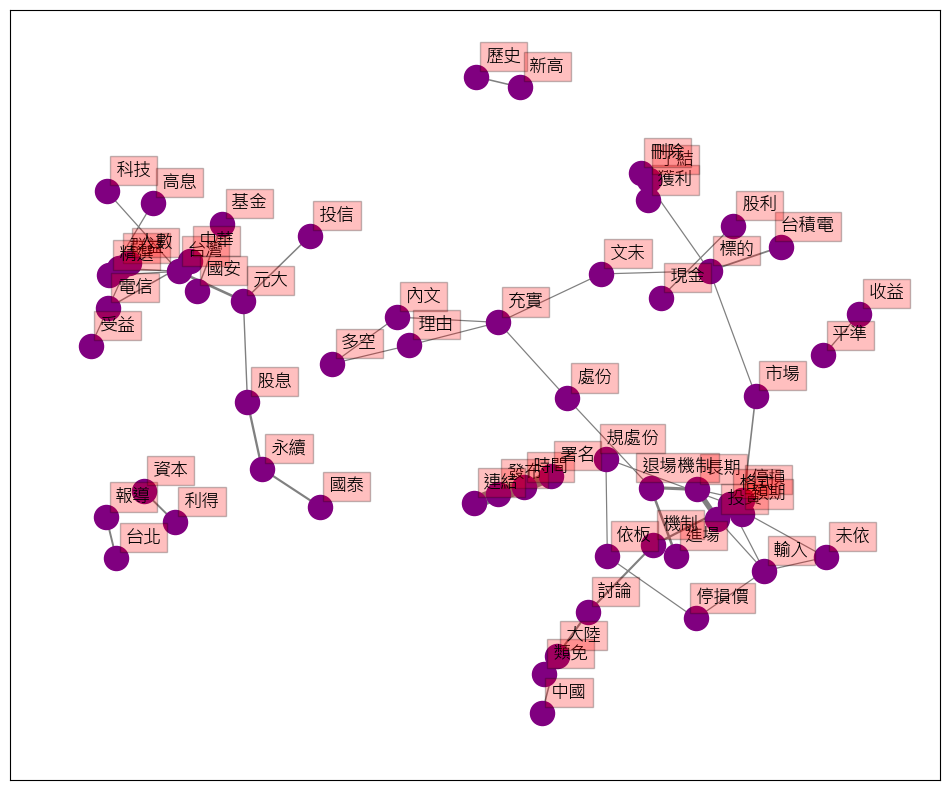

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

從網路圖我們可以發現：
+ <ins>進場、長期投資、退場機制、停損</ins>很常被一起討論，原因也很好理解要投資首要必須知道的就是：知道甚麼時候進場？甚麼時候出場？怎麼設停損點？
+ <ins>台灣、科技、歷史、新高</ins>被一起討論居多，可能原因為在最近的幾年科技股持續帶領台股創新高。
+ <ins>預期、市場、標的</ins>被一起討論的原因可能是，新手常常尋求投資標的的建議。

## <ins><strong>Pairwise correlation</strong></ins>
計算兩個詞彙間的相關性 Pearson correlation

In [28]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇 航空 討論 剛剛 頻道 邦尼 測試 星宇 經濟艙 有什麼 東西 快充 實測 影片...
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...,意外 準備 反彈 南山 人壽 澄清 部位 股價 根本 過度 反應 反彈 最少 潤泰新 存股 ...
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...,技術分析 公說 公有 婆說婆有理 沒道理 屁孩會 學藝 不精 畫好 解釋 準的 棒棒 不準 ...


In [29]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一年,一次,一直,一點,上半年,上市,上漲,下半年,下跌,不用,...,預估,預期,預測,預計,題材,顯示,風險,高息,高點,鴻海
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2864,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2865,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一年,一次,一直,一點,上半年,上市,上漲,下半年,下跌,...,預估,預期,預測,預計,題材,顯示,風險,高息,高點,鴻海
0,一年,1.000000,0.164930,0.053040,0.105621,0.004557,0.050975,0.058486,0.035217,0.089272,...,0.071310,0.089490,0.052009,0.011819,0.003075,0.022759,0.108906,0.052503,0.047785,0.018637
1,一次,0.164930,1.000000,0.047757,0.042192,0.025593,-0.007386,0.021205,0.006425,0.090974,...,0.027472,0.069796,0.075316,0.035994,-0.012168,0.028792,0.084788,0.017124,0.010294,-0.021042
2,一直,0.053040,0.047757,1.000000,0.110762,0.001944,-0.000451,0.010341,0.002464,0.043497,...,-0.001842,-0.002284,0.015040,-0.001702,-0.009247,-0.011880,0.007298,-0.010815,0.024647,0.078771
3,一點,0.105621,0.042192,0.110762,1.000000,0.023729,-0.022452,0.027288,0.005216,0.038361,...,-0.001429,-0.003789,0.082849,-0.037547,0.009165,-0.029529,0.026930,-0.034930,0.013871,0.030673
4,上半年,0.004557,0.025593,0.001944,0.023729,1.000000,0.038847,0.045883,0.422385,0.038541,...,0.066472,0.246014,0.023867,0.064479,0.105260,0.018979,-0.004661,-0.010586,0.107776,-0.008627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,顯示,0.022759,0.028792,-0.011880,-0.029529,0.018979,0.056439,0.117669,0.027141,0.122211,...,0.071795,0.123316,0.042944,0.044321,-0.004750,1.000000,0.085315,0.055446,0.025418,0.007707
296,風險,0.108906,0.084788,0.007298,0.026930,-0.004661,0.045789,0.045891,0.015887,0.181447,...,0.044557,0.138237,0.104016,0.035654,-0.015811,0.085315,1.000000,0.033418,0.052976,-0.005961
297,高息,0.052503,0.017124,-0.010815,-0.034930,-0.010586,0.084033,0.074454,-0.001578,0.045192,...,0.048534,0.038464,-0.003687,-0.000121,0.024507,0.055446,0.033418,1.000000,-0.017380,0.012498
298,高點,0.047785,0.010294,0.024647,0.013871,0.107776,-0.002746,0.091977,0.160518,0.046383,...,0.099079,0.190902,0.028787,-0.001244,0.106325,0.025418,0.052976,-0.017380,1.000000,0.048840


In [31]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
64985,發布,署名,0.861760
55716,署名,發布,0.861760
65063,連結,署名,0.725145
79116,署名,連結,0.725145
79085,發布,連結,0.655086
55763,連結,發布,0.655086
47058,退場機制,標的,0.634842
77556,標的,退場機制,0.634842
46951,格式,標的,0.629664
45456,標的,格式,0.629664


比較有價值的資訊可能是<ins>標的、退場機制</ins>，可能跟探討投資標的的退場機制是如何設定的。

### 和 「退場機制」, 「停損」, 「進場」, 「台積電」 相關性最高的 10 個詞彙

In [32]:
back_sum = word_cor_df[(word_cor_df["word1"] == "退場機制")].sort_values(by = ['cor'], ascending = False).head(10)
stop_sum = word_cor_df[(word_cor_df["word1"] == "停損")].sort_values(by = ['cor'], ascending = False).head(10)
in_sum = word_cor_df[(word_cor_df["word1"] == "進場")].sort_values(by = ['cor'], ascending = False).head(10)
TSMC_sum = word_cor_df[(word_cor_df["word1"] == "台積電")].sort_values(by = ['cor'], ascending = False).head(10)

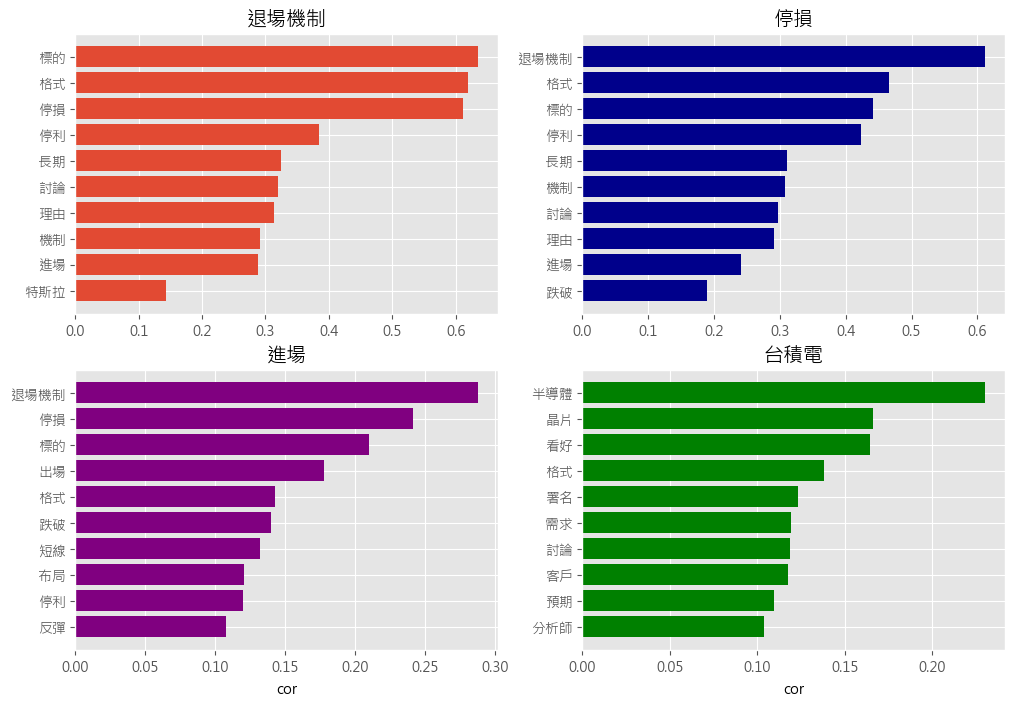

In [33]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(221)
plt.title('退場機制')
plt.barh(back_sum['word2'],back_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(222)
plt.title('停損')
plt.barh(stop_sum['word2'],stop_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.subplot(223)
plt.title('進場')
plt.xlabel('cor')
plt.barh(in_sum['word2'],in_sum['cor'],color="purple")
plt.gca().invert_yaxis()

plt.subplot(224)
plt.title('台積電')
plt.xlabel('cor')
plt.barh(TSMC_sum['word2'],TSMC_sum['cor'],color="green")
plt.gca().invert_yaxis()

plt.show()

先關係數圖可以發現：
+ <ins>進場、停損、退場機制</ins>比較息息相關，彼此都是彼此相關性前10
+ 退場機制&停損：相關性跟<ins>標的、停損、停利</ins>較高，可以推測可能在說明，當你在投資一個標的是，要有完善的停損點和退場機制，當虧損達停損點時及時出場。
+ 進場：相關性則跟<ins>停損、短線、布局、出場</ins>較高，可以推測可能在說明，在進場前也要考慮如何布局？是做短線還是長線？如果跌破停損點該如何出場？
+ 台積電：可以從中推斷出，分析師普遍都看好台積電的，也可以得知我們的護國神山是半導體晶片產業的~~

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [34]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [35]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,經濟,中國,0.416947
1,美國,中國,0.302891
2,標的,停損,0.442183
3,退場機制,停損,0.611752
4,長期,停損,0.311076
...,...,...,...
57,投資,長期,0.354844
58,標的,長期,0.378757
59,退場機制,長期,0.324439
60,成長,預期,0.305753


In [36]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

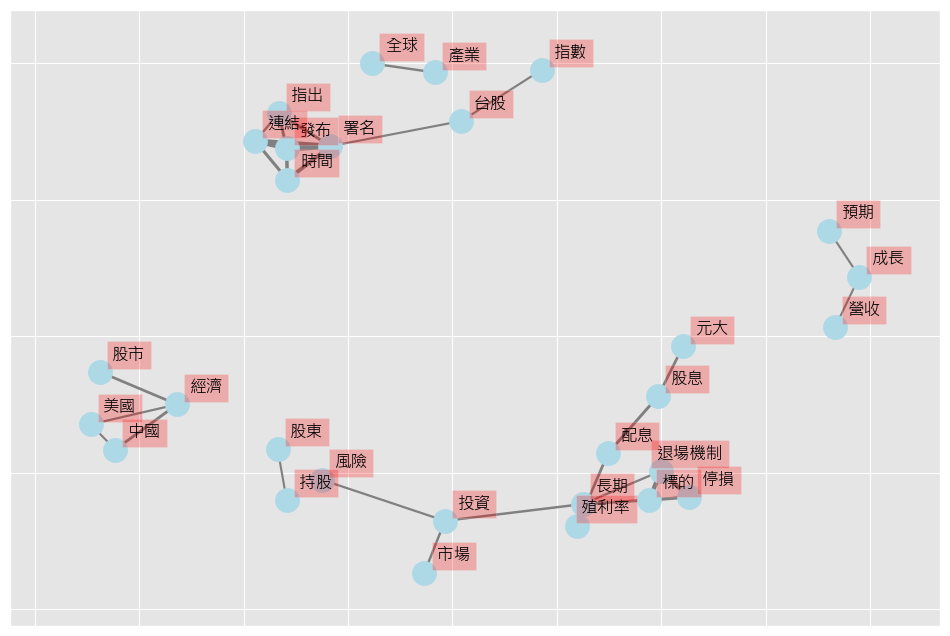

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

從網路圖我們可以發現：
+ 中下：主要在探討元大金控創歷年來次高的現金殖利率（3.6%），配息來到每股1.3元股利
+ 左：可能在講述中美關係對經濟股市的影響
+ 中上：對於股票新鮮人而言，可能在詢問如何通過大盤指數來設定停損點即時出場，尤其是長期投資時
+ 右：許多人也會關注股票的預期營收成長多少

## <ins><strong>計算文章相似度</ins></strong>
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

In [38]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,標的 星宇 航空 討論 剛剛 頻道 邦尼 測試 星宇 經濟艙 有什麼 東西 快充 實測 影片...
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...,意外 準備 反彈 南山 人壽 澄清 部位 股價 根本 過度 反應 反彈 最少 潤泰新 存股 ...
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...,技術分析 公說 公有 婆說婆有理 沒道理 屁孩會 學藝 不精 畫好 解釋 準的 棒棒 不準 ...


In [39]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一年,一次,一直,一點,上半年,上市,上漲,下半年,下跌,不用,...,預估,預期,預測,預計,題材,顯示,風險,高息,高點,鴻海
0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.393415,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.174923,0.000000,0.219443,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.201046,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.06693,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0
2863,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.108801,0.000000,0.0
2864,0.0,0.0,0.000000,0.000000,0.0,0.432633,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0
2865,0.0,0.0,0.088924,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0


計算文章間的cosine similarity

In [40]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [41]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.335851
2,0.032581
3,0.191616
4,0.000000
...,...
2862,0.128890
2863,0.079283
2864,0.000000
2865,0.199364


In [42]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[標的]星宇航空座艙科技點滿多,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...
187,0.527459,[標的]2615萬海下海玩69,https://www.ptt.cc/bbs/Stock/M.1681448493.A.DC...
1054,0.491548,[標的]2603長榮2637慧洋航運下半年通膨再起多,https://www.ptt.cc/bbs/Stock/M.1690867320.A.35...
2182,0.488235,Re:[標的]長榮（本週在融資加碼多單）,https://www.ptt.cc/bbs/Stock/M.1705113497.A.17...
2451,0.478611,Re:[標的]2603長榮高股息送錢多多多,https://www.ptt.cc/bbs/Stock/M.1708525683.A.83...
2423,0.459129,[標的]2603長榮高股息送錢多多多,https://www.ptt.cc/bbs/Stock/M.1708346252.A.29...
2814,0.451924,Re:[新聞]00940成分股大放異彩投信將砸161億買長,https://www.ptt.cc/bbs/Stock/M.1710850696.A.92...
2550,0.444992,Re:[請益]信貸＋融資再質押真的不會壓力很大嗎,https://www.ptt.cc/bbs/Stock/M.1709436167.A.AD...
325,0.443693,[新聞]航運股跳水PTT酸爆：179長榮何時解套？,https://www.ptt.cc/bbs/Stock/M.1683207844.A.CD...
20,0.442135,[新聞]長榮45個月年終「恐歸0」？員工驚曝內部,https://www.ptt.cc/bbs/Stock/M.1679486077.A.3B...


檢視與第187篇文章相似的文章

In [43]:
cos_df_187 = pd.DataFrame(cosine_matrix[187], columns=['cos_similarity'])

cos_df_187 = cos_df_187.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_187.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
187,1.000000,[標的]2615萬海下海玩69,https://www.ptt.cc/bbs/Stock/M.1681448493.A.DC...
2423,0.578387,[標的]2603長榮高股息送錢多多多,https://www.ptt.cc/bbs/Stock/M.1708346252.A.29...
2451,0.572463,Re:[標的]2603長榮高股息送錢多多多,https://www.ptt.cc/bbs/Stock/M.1708525683.A.83...
993,0.567091,[標的]2603長榮海運發股利行情多,https://www.ptt.cc/bbs/Stock/M.1690252856.A.68...
20,0.564669,[新聞]長榮45個月年終「恐歸0」？員工驚曝內部,https://www.ptt.cc/bbs/Stock/M.1679486077.A.3B...
2182,0.550281,Re:[標的]長榮（本週在融資加碼多單）,https://www.ptt.cc/bbs/Stock/M.1705113497.A.17...
2814,0.541030,Re:[新聞]00940成分股大放異彩投信將砸161億買長,https://www.ptt.cc/bbs/Stock/M.1710850696.A.92...
2787,0.539620,[標的]00919跟00940成分股暴跌,https://www.ptt.cc/bbs/Stock/M.1710731366.A.BE...
2242,0.537589,[新聞]快訊／春節恐無飛機搭！長榮機師取得合,https://www.ptt.cc/bbs/Stock/M.1705890625.A.3F...
1054,0.537498,[標的]2603長榮2637慧洋航運下半年通膨再起多,https://www.ptt.cc/bbs/Stock/M.1690867320.A.35...


## <ins><strong>建立Ngram預測模型</ins></strong>

In [44]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [45]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [46]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [47]:
text = '台積電'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 長期, probability: 0.0782
next word: 法說, probability: 0.0249
next word: 股價, probability: 0.0222
next word: 奈米, probability: 0.0169
next word: 多空, probability: 0.016


In [48]:
text = '元大'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 台灣, probability: 0.295
next word: 投信, probability: 0.17
next word: 股息, probability: 0.157
next word: 美債, probability: 0.0769
next word: 臺灣, probability: 0.0377


# 第二部分：文件分類-1

In [49]:
udn = df
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,enouch777,Stock,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""devidevi"", ""...",111.184.170.175,2023-03-21 02:21:56,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,YU1225,Stock,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sdhpipt"", ""c...",106.1.120.140,2023-03-22 02:22:39,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,peter98,Stock,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Altair"", ""cm...",73.195.162.171,2023-03-22 02:22:39,ptt


In [50]:
# 新增年/季度
udn["artDate"] = pd.to_datetime(udn["artDate"])
udn["Year_Quarter"] = udn["artDate"].dt.year.astype(str) + "/" + udn["artDate"].dt.quarter.astype(str) 

In [51]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"Year / Quarter: \n{udn['Year_Quarter'].value_counts()}")

number of posts: 2867
date range: (Timestamp('2023-03-21 00:30:56'), Timestamp('2024-03-21 19:11:51'))
Year / Quarter: 
Year_Quarter
2024/1    768
2023/2    690
2023/4    656
2023/3    646
2023/1    107
Name: count, dtype: int64


### 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [52]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,Year_Quarter
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,標的星宇航空座艙科技點滿多,2023-03-21 00:30:56,enouch777,Stock,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""devidevi"", ""...",111.184.170.175,2023-03-21 02:21:56,ptt,2023/1
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,標的潤泰全潤泰新反彈肉最少,2023-03-21 08:03:41,YU1225,Stock,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sdhpipt"", ""c...",106.1.120.140,2023-03-22 02:22:39,ptt,2023/1
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,請益線仙能靠技術分析全職操盤穩定獲利嗎,2023-03-21 08:14:29,peter98,Stock,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Altair"", ""cm...",73.195.162.171,2023-03-22 02:22:39,ptt,2023/1


In [53]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "Year_Quarter"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,Year_Quarter
0,標的星宇航空座艙科技點滿多標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有...,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,2023/1
1,標的潤泰全潤泰新反彈肉最少今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最...,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,2023/1
2,請益線仙能靠技術分析全職操盤穩定獲利嗎技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就...,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,2023/1
3,請益線仙能靠技術分析全職操盤穩定獲利嗎有一招技術分析你可能聽過就是創新高的股票上無壓力會繼續...,https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...,2023/1
4,新聞外資大砍金融股中信金遭賣萬張最原文標題外資大砍金融股中信金遭賣萬張最慘新光金玉山金同步遭...,https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...,2023/1


### 斷詞

In [54]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [55]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

,content,artUrl,Year_Quarter,words
0,標的星宇航空座艙科技點滿多標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有...,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,2023/1,標的 星宇 航空 座艙 科技 滿多 標的 星宇 航空 討論 剛剛 頻道 邦尼 測試 星宇 經...
1,標的潤泰全潤泰新反彈肉最少今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最...,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,2023/1,標的 潤泰 潤泰新 反彈 最少 意外 準備 反彈 南山 人壽 澄清 部位 股價 根本 過度 ...
2,請益線仙能靠技術分析全職操盤穩定獲利嗎技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就...,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,2023/1,請益 線仙能 技術分析 全職 操盤 穩定 獲利 技術分析 公說 公有 婆說婆有理 沒道理 屁...
3,請益線仙能靠技術分析全職操盤穩定獲利嗎有一招技術分析你可能聽過就是創新高的股票上無壓力會繼續...,https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...,2023/1,請益 線仙能 技術分析 全職 操盤 穩定 獲利 一招 技術分析 聽過 創新高 股票 壓力 繼...
4,新聞外資大砍金融股中信金遭賣萬張最原文標題外資大砍金融股中信金遭賣萬張最慘新光金玉山金同步遭...,https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...,2023/1,新聞 外資 大砍 金融股 中信金 遭賣 萬張 外資 大砍 金融股 中信金 遭賣 萬張 最慘 ...


## <ins><strong>比較不同模型效果</strong></ins>

In [56]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

now training: clf_logistic


c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

      2023/1       0.00      0.00      0.00        78
      2023/2       0.36      0.38      0.37       478
      2023/3       0.36      0.29      0.32       437
      2023/4       0.37      0.34      0.35       464
      2024/1       0.42      0.54      0.47       549

    accuracy                           0.38      2006
   macro avg       0.30      0.31      0.30      2006
weighted avg       0.36      0.38      0.37      2006

now training: clf_dtree
              precision    recall  f1-score   support

      2023/1       0.04      0.03      0.03        78
      2023/2       0.29      0.32      0.30       478
      2023/3       0.28      0.27      0.28       437
      2023/4       0.29      0.28      0.28       464
      2024/1       0.33      0.34      0.33       549

    accuracy                           0.29      2006
   macro avg       0.25      0.25      0.24      2006
weighted avg       0.29      0.29      0.29      2006

c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

      2023/1       0.00      0.00      0.00        78
      2023/2       0.36      0.39      0.37       478
      2023/3       0.40      0.26      0.32       437
      2023/4       0.42      0.33      0.37       464
      2024/1       0.40      0.60      0.48       549

    accuracy                           0.39      2006
   macro avg       0.31      0.32      0.31      2006
weighted avg       0.38      0.39      0.37      2006

now training: clf_rf
              precision    recall  f1-score   support

      2023/1       0.00      0.00      0.00        78
      2023/2       0.34      0.40      0.37       478
      2023/3       0.36      0.24      0.29       437
      2023/4       0.43      0.37      0.40       464
      2024/1       0.40      0.56      0.47       549

    accuracy                           0.39      2006
   macro avg       0.31      0.31      0.31      2006
weighted avg       0.37      0.39      0.37      2006



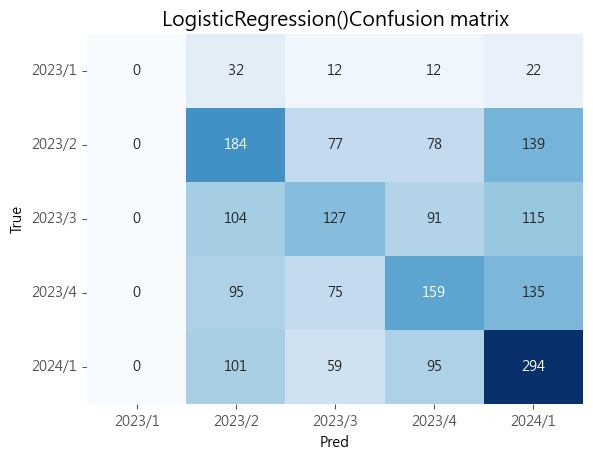

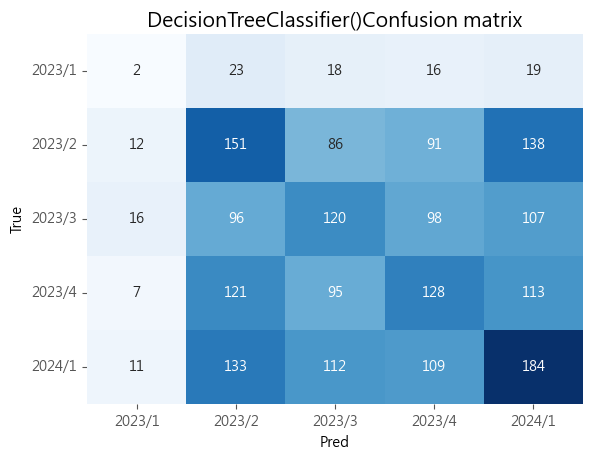

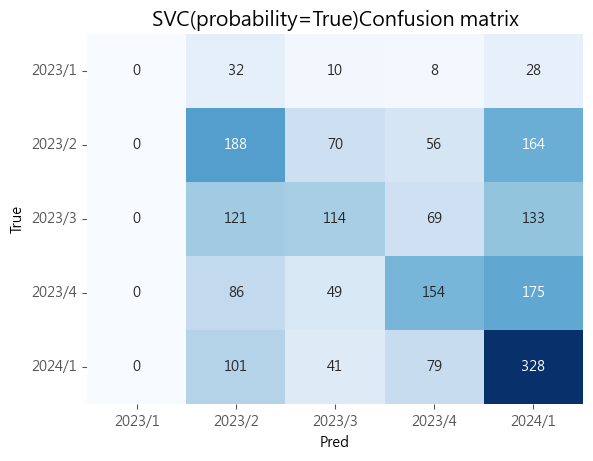

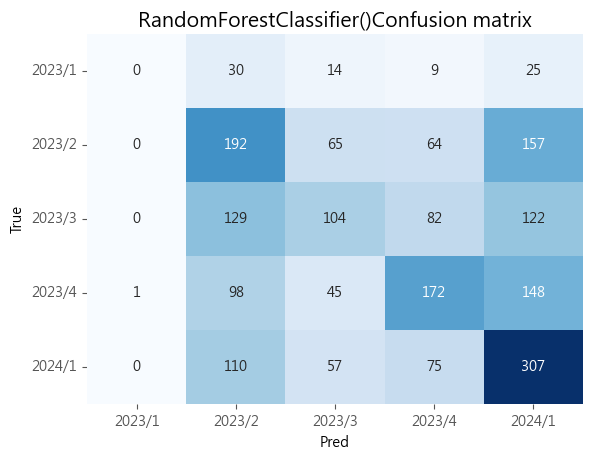

In [59]:
# 準備訓練資料
data = udn
X = data["words"]
y = data["Year_Quarter"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [60]:
result_set['clf_svm']

{'2023/1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 78},
 '2023/2': {'precision': 0.3560606060606061,
  'recall': 0.39330543933054396,
  'f1-score': 0.3737574552683897,
  'support': 478},
 '2023/3': {'precision': 0.4014084507042254,
  'recall': 0.2608695652173913,
  'f1-score': 0.31622746185852985,
  'support': 437},
 '2023/4': {'precision': 0.4207650273224044,
  'recall': 0.33189655172413796,
  'f1-score': 0.37108433734939766,
  'support': 464},
 '2024/1': {'precision': 0.3961352657004831,
  'recall': 0.5974499089253188,
  'f1-score': 0.476397966594045,
  'support': 549},
 'accuracy': 0.39082751744765704,
 'macro avg': {'precision': 0.3148738699575438,
  'recall': 0.3167042930394784,
  'f1-score': 0.30749344421407243,
  'support': 2006},
 'weighted avg': {'precision': 0.37802876181549205,
  'recall': 0.39082751744765704,
  'f1-score': 0.37416404817583204,
  'support': 2006}}

In [61]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'2023/1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 78},
 '2023/2': {'f1-score': 0.3737574552683897,
            'precision': 0.3560606060606061,
            'recall': 0.39330543933054396,
            'support': 478},
 '2023/3': {'f1-score': 0.31622746185852985,
            'precision': 0.4014084507042254,
            'recall': 0.2608695652173913,
            'support': 437},
 '2023/4': {'f1-score': 0.37108433734939766,
            'precision': 0.4207650273224044,
            'recall': 0.33189655172413796,
            'support': 464},
 '2024/1': {'f1-score': 0.476397966594045,
            'precision': 0.3961352657004831,
            'recall': 0.5974499089253188,
            'support': 549},
 'accuracy': 0.39082751744765704,
 'macro avg': {'f1-score': 0.30749344421407243,
               'precision': 0.3148738699575438,
               'recall': 0.3167042930394784,
               'support': 2006},
 'weighted avg': {'f1-score': 0.37416404817583204,


In [62]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      2023/1       0.00      0.00      0.00        29
      2023/2       0.42      0.48      0.45       212
      2023/3       0.41      0.22      0.29       209
      2023/4       0.41      0.34      0.37       192
      2024/1       0.42      0.67      0.52       219

    accuracy                           0.42       861
   macro avg       0.33      0.34      0.32       861
weighted avg       0.40      0.42      0.39       861



c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <ins><strong>分析可解釋模型的結果</ins></strong>

### 各字詞特徵的estimate係數

In [63]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

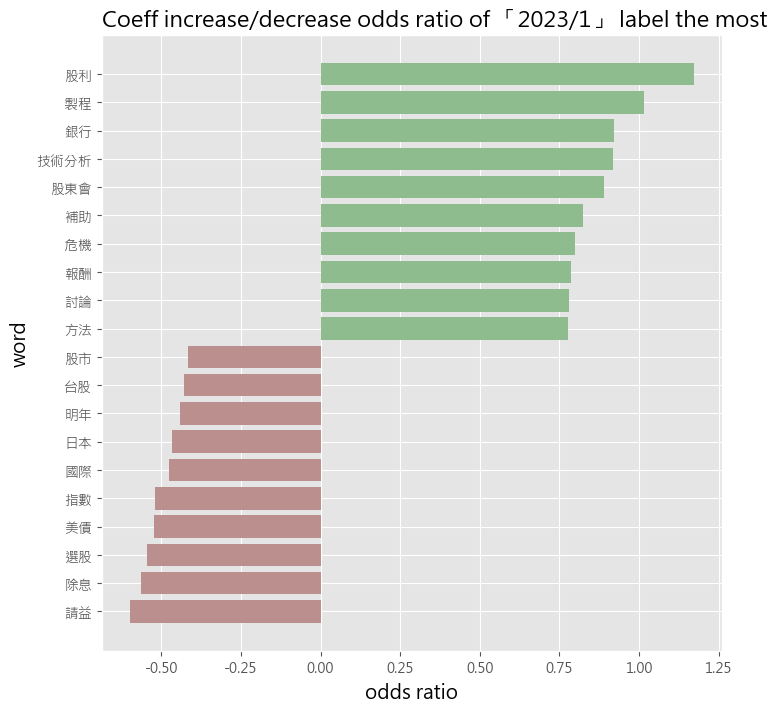

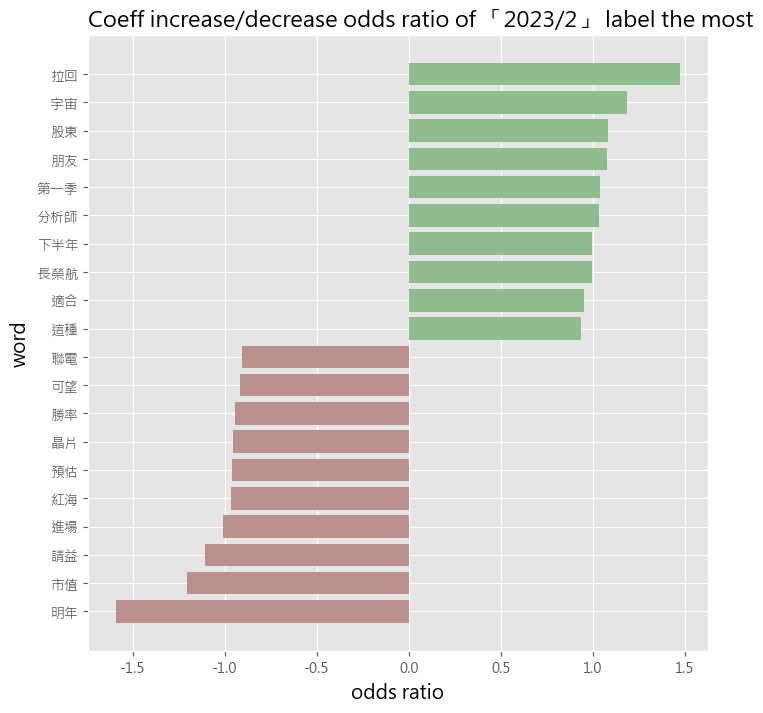

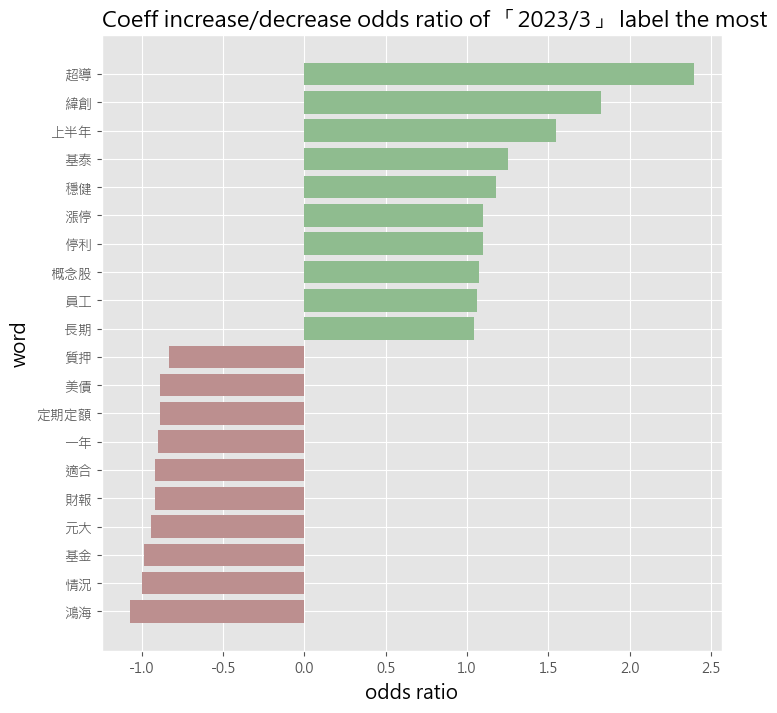

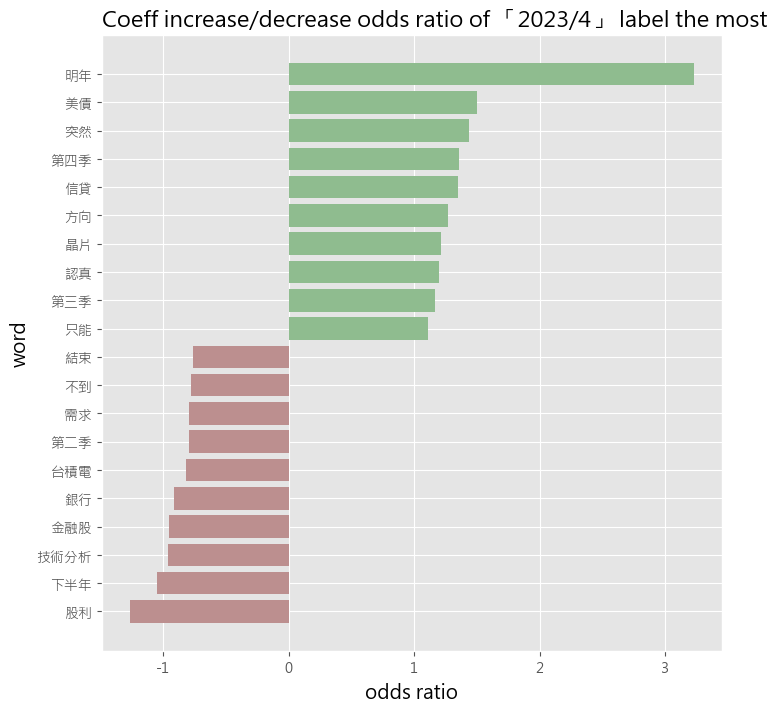

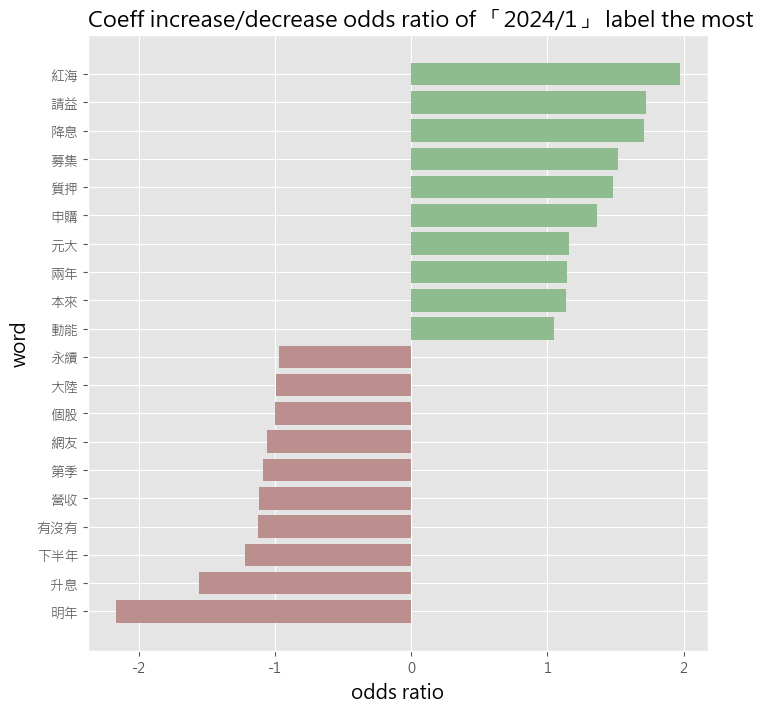

In [64]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

透過上述圖表可以發現：
+ 2023/1：股利通常在1、2月的時候發，所以Q1多了很多股利、股東會、報酬等字眼
+ 2023/2：對比新聞可以得知長榮航在2023年Q2純收益增長了兩倍
+ 2023/3：當時常溫超導體引起旋風，AI股也因Nvidia大漲而牽動台股
+ 2023/4：美財部在2023年Q4擴大發行美債
+ 2024/1：元大金控在2024年Q1獲利超60億，年增6成；同時期，鴻海營收也持續創同期新高

# 第二部分：文件分類-2

In [71]:
udn2 = pd.read_csv("data/Stock_data.csv")  # 匯資料
udn2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709223923....,[請益]兩房物件請益,2024-03-01 00:25:19,a96932000,home_sale,"不好意思又來叨擾房版了\n\n目前有看到高雄兩個物件,感覺各有勝負,想詢問看看版上的意見\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""themlb09"", ""...",220.143.164.133,2024-03-01 01:46:26,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709232819....,[請益]冠德安沐居要每坪200萬，冠德大直綻每坪,2024-03-01 02:53:37,gigaman,home_sale,請問各位先進，冠德安沐居要每坪200萬，冠德大直綻每坪160萬，雖然都在捷運出口，但\n也比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luckysmallsu...",42.70.108.144,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt


In [72]:
# 看看有幾篇文章
print(f"number of posts: {udn2.shape[0]}")
print(f"date range: {(udn2['artDate'].min(), udn2['artDate'].max())}")
print(f"category: \n{udn2['artCatagory'].value_counts()}")

number of posts: 5102
date range: ('2024-03-01 00:00:05', '2024-03-31 23:28:24')
category: 
artCatagory
Stock          2793
home_sale      1865
Lifeismoney     444
Name: count, dtype: int64


In [73]:
# 過濾 nan 的資料
udn2 = udn2.dropna(subset=['artTitle'])
udn2 = udn2.dropna(subset=['artContent'])
# 移除網址格式
udn2["artContent"] = udn2.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn2["artTitle"] = udn2["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn2["artContent"] = udn2.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn2["artTitle"] = udn2["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709223923....,請益兩房物件請益,2024-03-01 00:25:19,a96932000,home_sale,不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見兩者的總價室內坪...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""themlb09"", ""...",220.143.164.133,2024-03-01 01:46:26,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709232819....,請益冠德安沐居要每坪萬冠德大直綻每坪,2024-03-01 02:53:37,gigaman,home_sale,請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷運出口但也比周邊貴一些這個價錢是貴在品牌嗎,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luckysmallsu...",42.70.108.144,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,新聞台灣金聯土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導具公股色彩的台灣金聯近年大舉在南台灣與...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt


In [74]:
# 留下 content
udn2["content"] = udn2["artTitle"] + udn2["artContent"]
udn2 = udn2[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn2.head()

,content,artUrl,artCatagory
0,請益兩房物件請益不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale
1,請益冠德安沐居要每坪萬冠德大直綻每坪請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷...,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale
2,新聞台灣金聯土地未運用有原因駁斥養地炒連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale
3,情報好房網月房價好房網重點縣市成交漲跌排行點選區域實價登錄趨勢年月重點縣市實價登錄漲跌排行新...,https://www.ptt.cc/bbs/home-sale/M.1709251729....,home_sale
4,新聞桃園版香榭大道要來了鐵路地下化將釋地範響出畫站次的在規任榭桃均桃參考這篇還在說沒發包出去...,https://www.ptt.cc/bbs/home-sale/M.1709252693....,home_sale


In [75]:
udn2["words"] = udn2["content"].apply(getToken).map(" ".join)
udn2.head()

,content,artUrl,artCatagory,words
0,請益兩房物件請益不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale,請益 兩房 物件 請益 不好意思 來叨擾 房版 高雄 兩個 物件 感覺 各有 勝負 詢問 看...
1,請益冠德安沐居要每坪萬冠德大直綻每坪請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷...,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale,請益 冠德 安沐居要 每坪 冠德 大直 每坪 請問 先進 冠德 安沐居要 每坪 冠德 大直 ...
2,新聞台灣金聯土地未運用有原因駁斥養地炒連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale,新聞 台灣 金聯 土地 運用 原因 駁斥 養地 連結 內文 台灣 金聯 土地 運用 原因 駁...
3,情報好房網月房價好房網重點縣市成交漲跌排行點選區域實價登錄趨勢年月重點縣市實價登錄漲跌排行新...,https://www.ptt.cc/bbs/home-sale/M.1709251729....,home_sale,情報 好房網 房價 好房網 重點 縣市 成交 漲跌 排行 點選 區域 實價 登錄 趨勢 重點...
4,新聞桃園版香榭大道要來了鐵路地下化將釋地範響出畫站次的在規任榭桃均桃參考這篇還在說沒發包出去...,https://www.ptt.cc/bbs/home-sale/M.1709252693....,home_sale,新聞 桃園 香榭 大道 要來 鐵路 地下化 釋地 範響 出畫 規任 桃均桃 參考 這篇 還在...


now training: clf_logistic
              precision    recall  f1-score   support

 Lifeismoney       0.98      0.89      0.93       329
       Stock       0.95      0.99      0.97      1970
   home_sale       0.97      0.95      0.96      1266

    accuracy                           0.96      3565
   macro avg       0.97      0.94      0.96      3565
weighted avg       0.96      0.96      0.96      3565

now training: clf_dtree
              precision    recall  f1-score   support

 Lifeismoney       0.82      0.92      0.87       329
       Stock       0.94      0.92      0.93      1970
   home_sale       0.91      0.91      0.91      1266

    accuracy                           0.92      3565
   macro avg       0.89      0.92      0.90      3565
weighted avg       0.92      0.92      0.92      3565

now training: clf_svm
              precision    recall  f1-score   support

 Lifeismoney       0.97      0.90      0.94       329
       Stock       0.96      0.98      0.97      1970
  

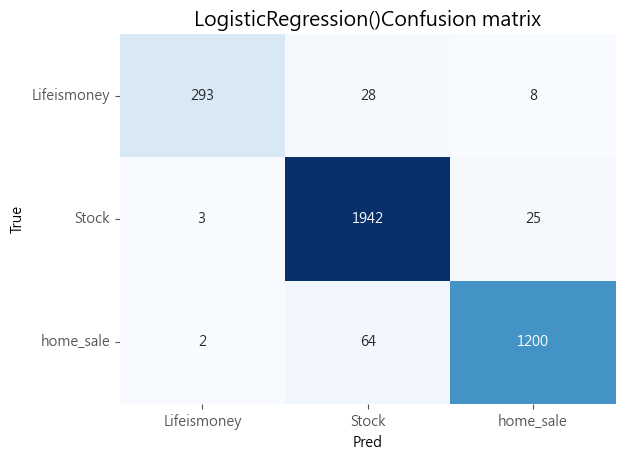

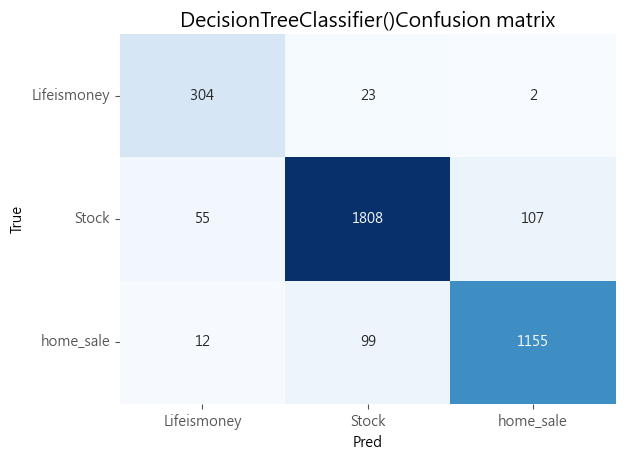

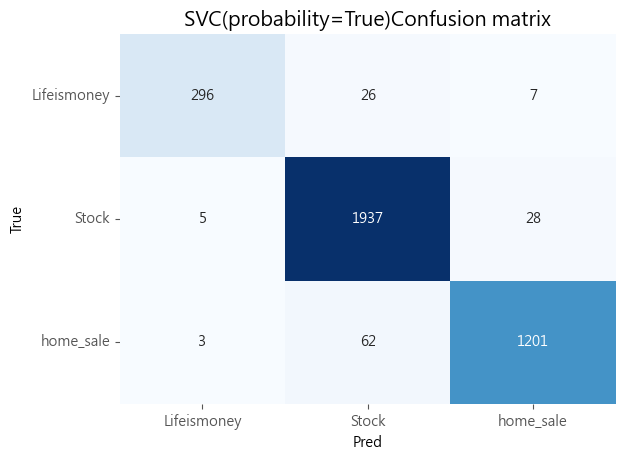

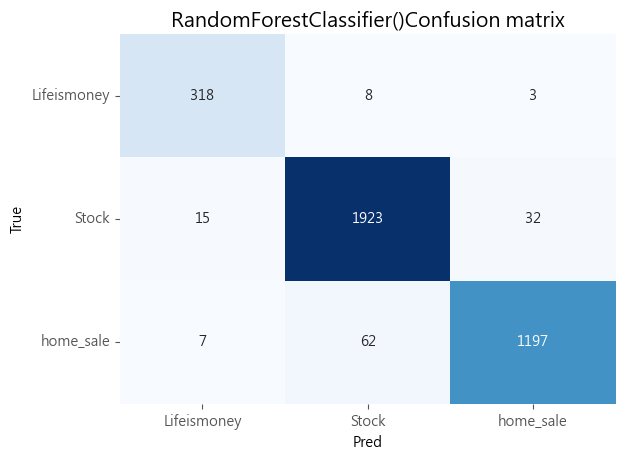

In [76]:
# 準備訓練資料
data = udn2
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [77]:
result_set['clf_rf']

{'Lifeismoney': {'precision': 0.9352941176470588,
  'recall': 0.9665653495440729,
  'f1-score': 0.9506726457399103,
  'support': 329},
 'Stock': {'precision': 0.9648770697441044,
  'recall': 0.9761421319796955,
  'f1-score': 0.9704769114307343,
  'support': 1970},
 'home_sale': {'precision': 0.9715909090909091,
  'recall': 0.9454976303317536,
  'f1-score': 0.9583666933546837,
  'support': 1266},
 'accuracy': 0.9643758765778401,
 'macro avg': {'precision': 0.9572540321606908,
  'recall': 0.962735037285174,
  'f1-score': 0.9598387501751094,
  'support': 3565},
 'weighted avg': {'precision': 0.964531187380325,
  'recall': 0.9643758765778401,
  'f1-score': 0.9643486815579261,
  'support': 3565}}

In [78]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'Lifeismoney': {'f1-score': 0.9506726457399103,
                 'precision': 0.9352941176470588,
                 'recall': 0.9665653495440729,
                 'support': 329},
 'Stock': {'f1-score': 0.9704769114307343,
           'precision': 0.9648770697441044,
           'recall': 0.9761421319796955,
           'support': 1970},
 'accuracy': 0.9643758765778401,
 'home_sale': {'f1-score': 0.9583666933546837,
               'precision': 0.9715909090909091,
               'recall': 0.9454976303317536,
               'support': 1266},
 'macro avg': {'f1-score': 0.9598387501751094,
               'precision': 0.9572540321606908,
               'recall': 0.962735037285174,
               'support': 3565},
 'weighted avg': {'f1-score': 0.9643486815579261,
                  'precision': 0.964531187380325,
                  'recall': 0.9643758765778401,
                  'support': 3565}}


In [80]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Lifeismoney       0.98      0.96      0.97       115
       Stock       0.96      0.98      0.97       817
   home_sale       0.98      0.95      0.97       596

    accuracy                           0.97      1528
   macro avg       0.97      0.96      0.97      1528
weighted avg       0.97      0.97      0.97      1528



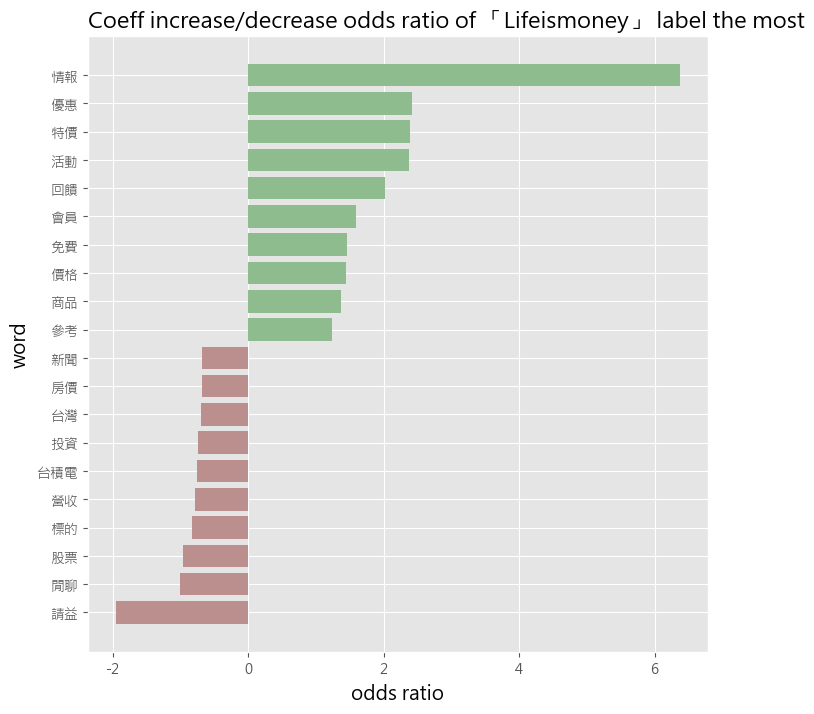

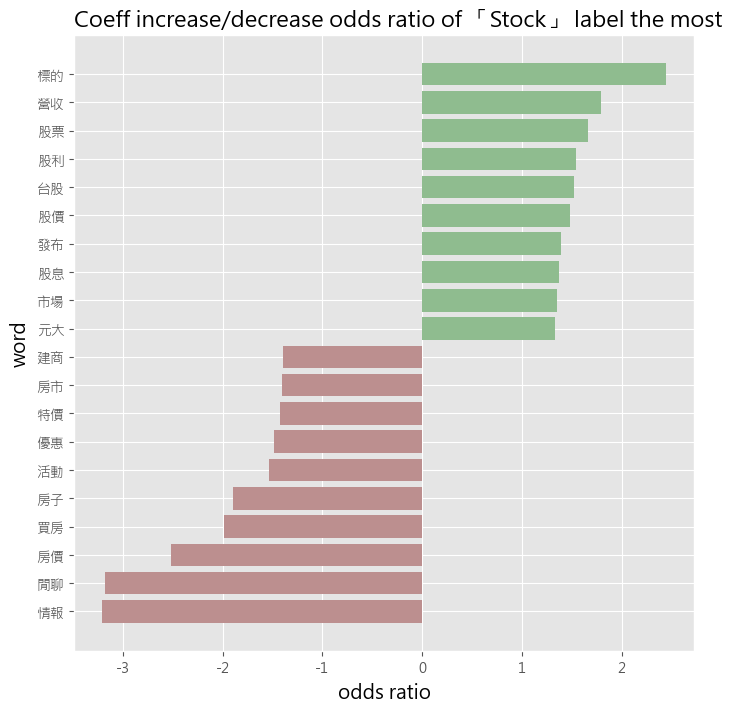

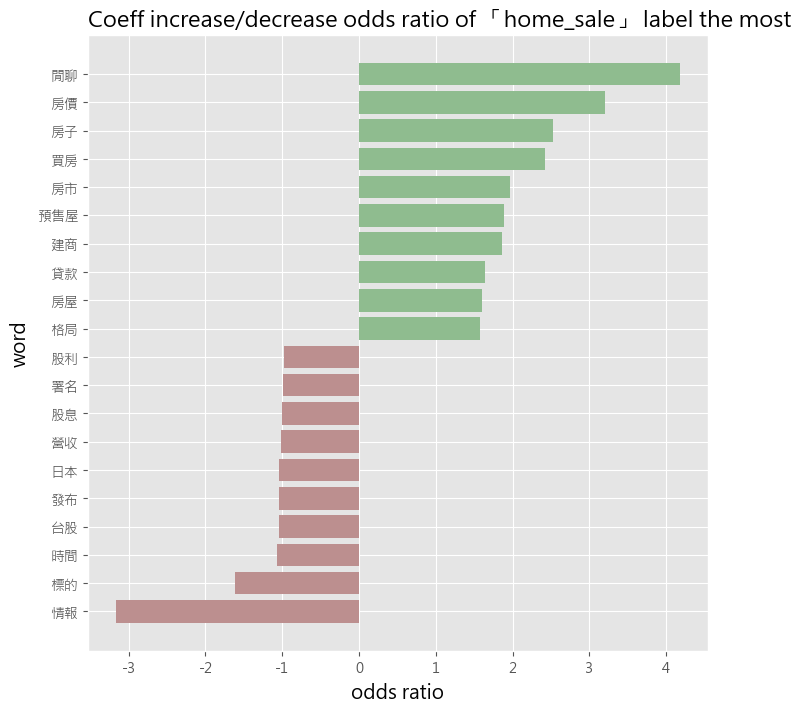

In [81]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

透過上述圖表可以發現：
+ 省錢版：通常會有優惠、免費、折扣、特價之類的字眼，而這些字眼通常跟價格減少有關係，出現在省錢版也合理
+ 股票版：有標的、股票、股利、台股等與股票相關的字眼出現
+ 房價版：擇友房價、買房、預售屋等與房價息息相關的字眼出現
<br><br>另外我們也發現當odds ratio負相關愈大的字眼出現在斷詞中時，則愈可能將該篇文章不判定在該類別